In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Set font and styling
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-darkgrid')

# Add project path
sys.path.append(os.path.dirname(os.path.abspath('')))

print("✓ Import completed")

✓ Import completed


In [2]:
# Import environment and configuration
from src.Environment import ChargingIntegratedEnvironment
from config.config_manager import ConfigManager

# Initialize environment
num_vehicles = 20
num_stations = 8

env = ChargingIntegratedEnvironment(
    num_vehicles=num_vehicles,
    num_stations=num_stations,
    random_seed=42,
    use_intense_requests=False
)

print(f"✓ Environment initialized: {num_vehicles} vehicles, {num_stations} charging stations")
print(f"✓ Grid size: {env.grid_size}x{env.grid_size}")
print(f"✓ Number of hotspots: {env.hotspot_locations_num}")
print(f"✓ Hotspot locations: {env.hotspot_locations}")

Using fallback logging instead of TensorBoard to avoid protobuf compatibility issues
✅ 配置加载成功: c:\Users\miaoz\OneDrive\桌面\EV-ADP-1\config\config_adp.json
✓ Environment random seed set to 42
✓ Vehicles initialized with fixed seed 42 - consistent initial states
[(3, 3), (10, 3), (3, 10), (10, 10)]
✓ Initialized integrated environment: 20 vehicles, 8 charging stations
✓ Environment initialized: 20 vehicles, 8 charging stations
✓ Grid size: 15x15
✓ Number of hotspots: 4
✓ Hotspot locations: [(3, 3), (10, 3), (3, 10), (10, 10)]


## 1. Hotspot Visualization

Display the 4 hotspot zones on the grid

In [3]:
# Find an EV vehicle
ev_id = None
for vehicle_id, vehicle in env.vehicles.items():
    if vehicle['type'] == 1:  # EV
        ev_id = vehicle_id
        break

if ev_id is None:
    print("❌ No EV vehicle found")
else:
    print(f"✓ Found EV vehicle ID: {ev_id}")
    print(f"  Current location: {env.vehicles[ev_id]['location']}")
    print(f"  Current coordinates: {env.vehicles[ev_id]['coordinates']}")
    print(f"  Current battery: {env.vehicles[ev_id]['battery']:.2%}")

✓ Found EV vehicle ID: 0
  Current location: 25
  Current coordinates: (10, 1)
  Current battery: 51.13%


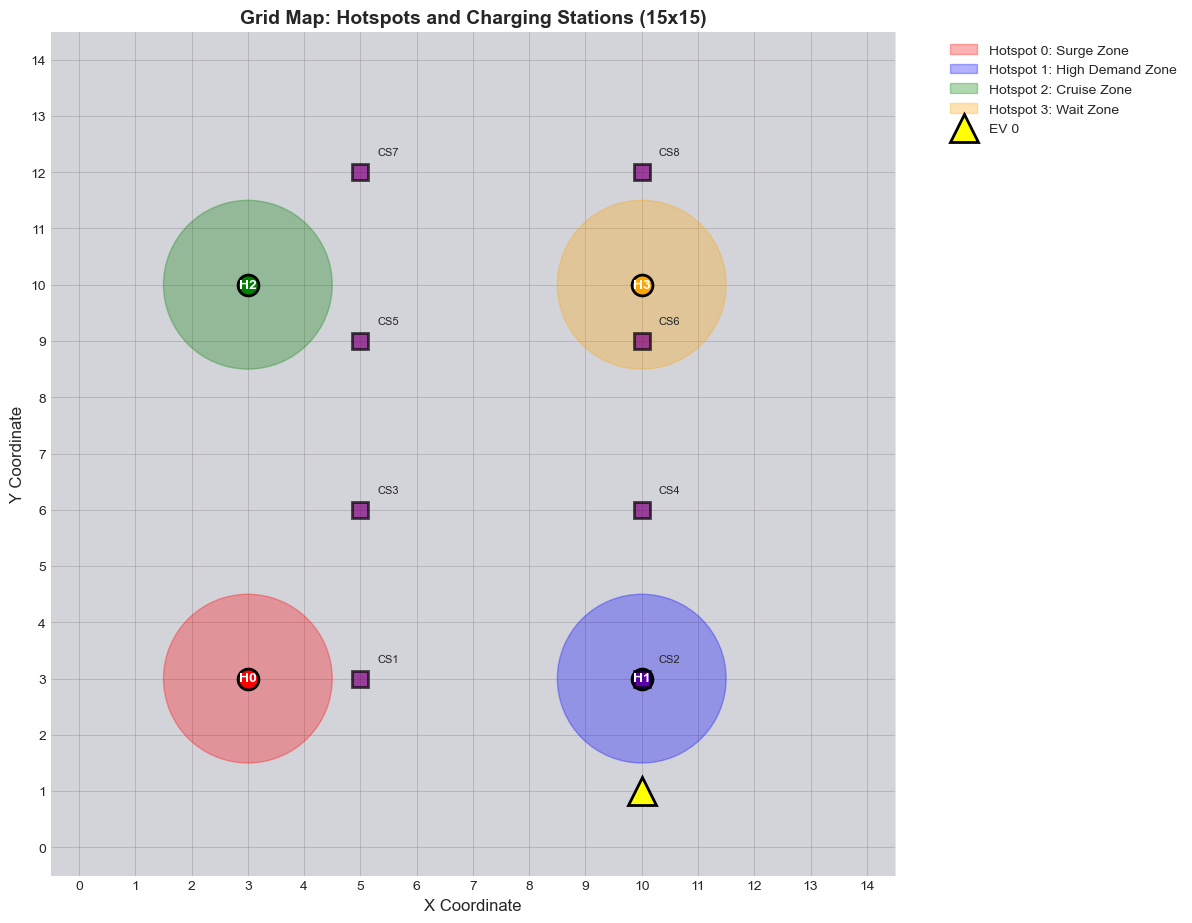

✓ Hotspot map saved to results/hotspot_map.png


In [4]:
# Visualize grid with hotspots and charging stations
fig, ax = plt.subplots(figsize=(12, 12))

# Create grid background
grid_size = env.grid_size
grid_background = np.zeros((grid_size, grid_size))
ax.imshow(grid_background, cmap='gray', alpha=0.1, origin='lower')

# Mark hotspot zones with different colors
hotspot_colors = ['red', 'blue', 'green', 'orange']
hotspot_names = ['Surge Zone', 'High Demand Zone', 'Cruise Zone', 'Wait Zone']

for idx, (hx, hy) in enumerate(env.hotspot_locations):
    # Draw hotspot circle
    circle = plt.Circle((hx, hy), 1.5, color=hotspot_colors[idx], alpha=0.3, label=f'Hotspot {idx}: {hotspot_names[idx]}')
    ax.add_patch(circle)
    # Mark center
    ax.plot(hx, hy, 'o', color=hotspot_colors[idx], markersize=15, markeredgecolor='black', markeredgewidth=2)
    ax.text(hx, hy, f'H{idx}', ha='center', va='center', fontsize=10, fontweight='bold', color='white')

# Mark charging stations
for station_id, station in env.charging_manager.stations.items():
    station_x = station.location % grid_size
    station_y = station.location // grid_size
    ax.plot(station_x, station_y, 's', color='purple', markersize=12, 
           markeredgecolor='black', markeredgewidth=2, alpha=0.7)
    ax.text(station_x + 0.3, station_y + 0.3, f'CS{station_id}', fontsize=8)

# Mark EV location
if ev_id is not None:
    ev_x, ev_y = env.vehicles[ev_id]['coordinates']
    ax.plot(ev_x, ev_y, '^', color='yellow', markersize=20, 
           markeredgecolor='black', markeredgewidth=2, label=f'EV {ev_id}')

# Grid settings
ax.set_xlim(-0.5, grid_size - 0.5)
ax.set_ylim(-0.5, grid_size - 0.5)
ax.set_xticks(range(grid_size))
ax.set_yticks(range(grid_size))
ax.grid(True, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.set_xlabel('X Coordinate', fontsize=12)
ax.set_ylabel('Y Coordinate', fontsize=12)
ax.set_title(f'Grid Map: Hotspots and Charging Stations ({grid_size}x{grid_size})', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('results/hotspot_map.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Hotspot map saved to results/hotspot_map.png")

## 2. Relocation Action Probabilities

Analyze the probability of different relocation actions (Wait, Surge, HighDemand, Cruise)


=== Relocation Action Probabilities ===
  Wait: 27.51%
  Surge: 24.55%
  HighDemand: 27.68%
  Cruise: 20.26%


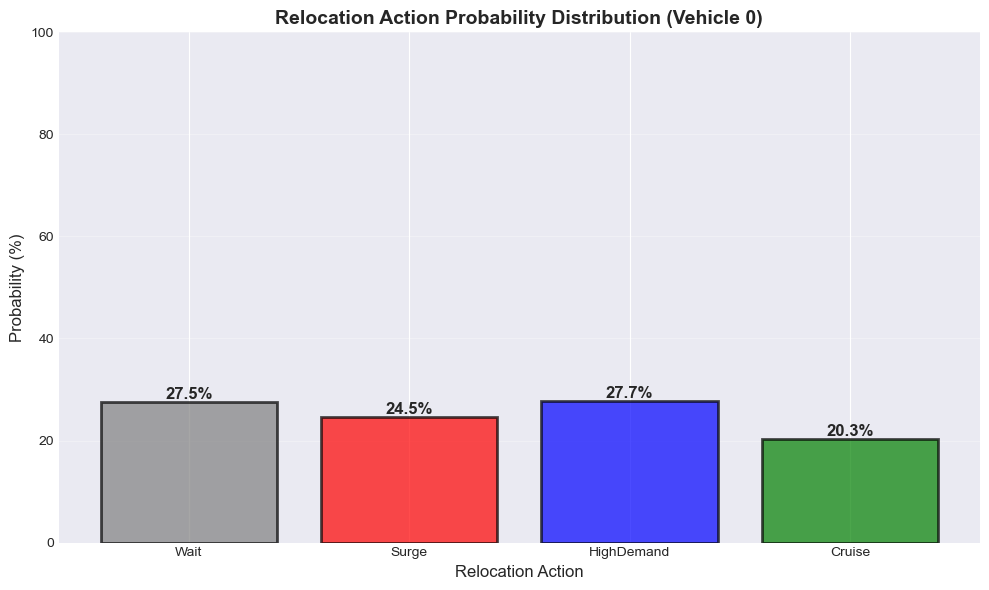

✓ Chart saved to results/relocation_probability_bar.png


In [5]:
# Calculate relocation probabilities for the EV
if ev_id is not None:
    reloc_probs = env.compute_ev_relocation_probability(ev_id)
    
    print("\n=== Relocation Action Probabilities ===")
    for action, prob in reloc_probs.items():
        print(f"  {action}: {prob*100:.2f}%")
    
    # Visualize as bar chart
    fig, ax = plt.subplots(figsize=(10, 6))
    
    actions = list(reloc_probs.keys())
    probs = [reloc_probs[a] * 100 for a in actions]
    colors_map = {'Wait': 'gray', 'Surge': 'red', 'HighDemand': 'blue', 'Cruise': 'green'}
    bar_colors = [colors_map.get(a, 'orange') for a in actions]
    
    bars = ax.bar(actions, probs, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=2)
    
    # Add value labels on bars
    for bar, prob in zip(bars, probs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{prob:.1f}%',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Relocation Action', fontsize=12)
    ax.set_ylabel('Probability (%)', fontsize=12)
    ax.set_title(f'Relocation Action Probability Distribution (Vehicle {ev_id})', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/relocation_probability_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Chart saved to results/relocation_probability_bar.png")

## 3. Relocation Probability vs Battery Level

Analyze how battery level affects relocation decisions

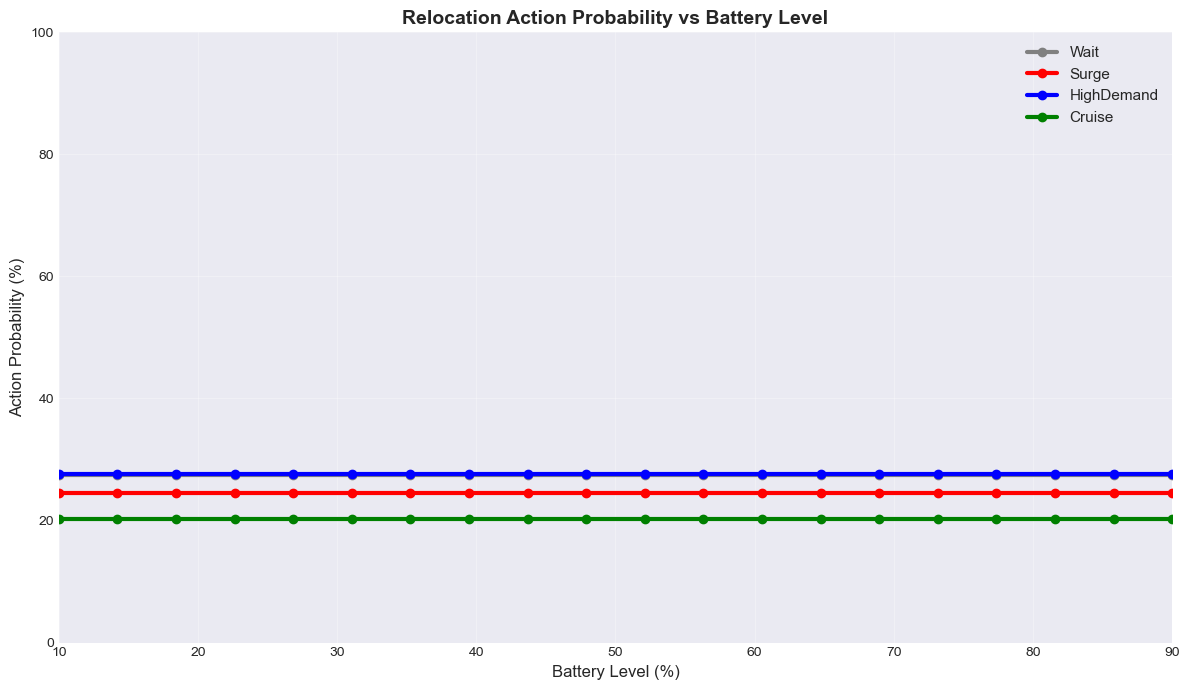

✓ Chart saved to results/relocation_vs_battery.png


In [6]:
# Scan different battery levels
battery_levels = np.linspace(0.1, 0.9, 20)
action_prob_history = {action: [] for action in ['Wait', 'Surge', 'HighDemand', 'Cruise']}

# Save original state
if ev_id is not None:
    original_battery = env.vehicles[ev_id]['battery']
    
    for battery in battery_levels:
        env.vehicles[ev_id]['battery'] = battery
        reloc_probs = env.compute_ev_relocation_probability(ev_id)
        
        for action in action_prob_history.keys():
            action_prob_history[action].append(reloc_probs.get(action, 0) * 100)
    
    # Restore original battery
    env.vehicles[ev_id]['battery'] = original_battery
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 7))
    
    colors_map = {'Wait': 'gray', 'Surge': 'red', 'HighDemand': 'blue', 'Cruise': 'green'}
    
    for action, probs in action_prob_history.items():
        if max(probs) > 1:  # Only show actions with significant probability
            ax.plot(battery_levels * 100, probs, linewidth=3, 
                   color=colors_map.get(action, 'orange'), 
                   label=action, marker='o', markersize=6)
    
    ax.set_xlabel('Battery Level (%)', fontsize=12)
    ax.set_ylabel('Action Probability (%)', fontsize=12)
    ax.set_title('Relocation Action Probability vs Battery Level', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=11)
    ax.set_xlim(10, 90)
    ax.set_ylim(0, 100)
    
    plt.tight_layout()
    plt.savefig('results/relocation_vs_battery.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Chart saved to results/relocation_vs_battery.png")

## 3.5. Hotspot Selection Probability vs SOC

Analyze how battery level affects the probability of relocating to each hotspot zone

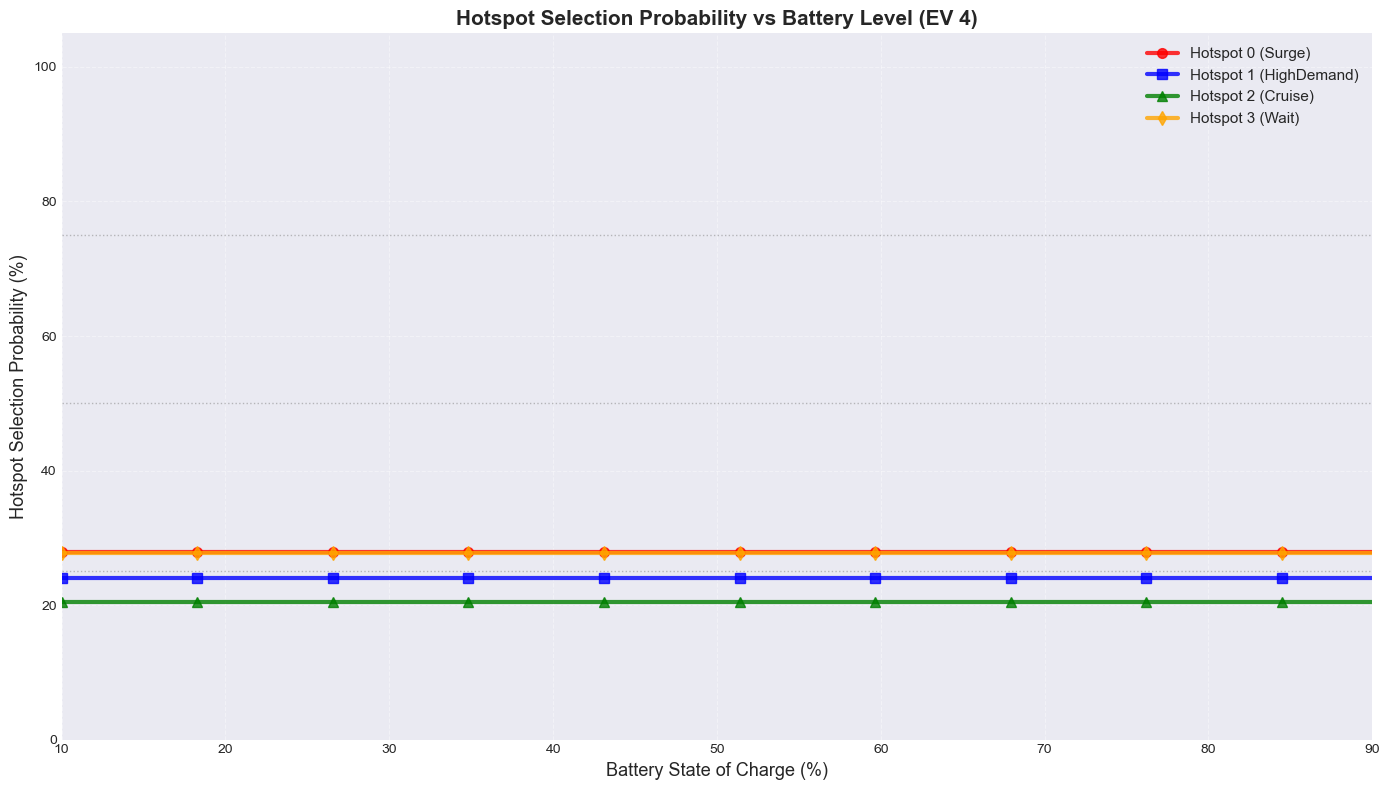

✓ Chart saved to results/hotspot_selection_vs_soc.png

📊 Hotspot Selection Statistics:

Hotspot 0:
  Average probability: 27.87%
  Max probability: 27.87% (at SOC=10.0%)
  Min probability: 27.87% (at SOC=10.0%)

Hotspot 1:
  Average probability: 24.03%
  Max probability: 24.03% (at SOC=10.0%)
  Min probability: 24.03% (at SOC=10.0%)

Hotspot 2:
  Average probability: 20.40%
  Max probability: 20.40% (at SOC=10.0%)
  Min probability: 20.40% (at SOC=10.0%)

Hotspot 3:
  Average probability: 27.70%
  Max probability: 27.70% (at SOC=10.0%)
  Min probability: 27.70% (at SOC=10.0%)


In [10]:
# Analyze hotspot selection probability across different SOC levels
# We'll track which hotspot each relocation action targets

# First, understand the mapping between actions and hotspots
# Based on the model, different relocation actions target different hotspots
action_to_hotspot = {
    'Surge': 0,      # Hotspot 0 - Surge Zone
    'HighDemand': 1, # Hotspot 1 - High Demand Zone
    'Cruise': 2,     # Hotspot 2 - Cruise Zone
    'Wait': 3        # Hotspot 3 - Wait Zone (or current location)
}

# Scan different SOC values
soc_values = np.linspace(0.1, 0.9, 30)
hotspot_selection_history = {f'Hotspot {i}': [] for i in range(len(env.hotspot_locations))}

if ev_id is not None:
    original_battery = env.vehicles[ev_id]['battery']
    
    for soc in soc_values:
        env.vehicles[ev_id]['battery'] = soc
        reloc_probs = env.compute_ev_relocation_probability(ev_id)
        
        # Map action probabilities to hotspot probabilities
        for action, hotspot_idx in action_to_hotspot.items():
            hotspot_key = f'Hotspot {hotspot_idx}'
            prob = reloc_probs.get(action, 0) * 100
            hotspot_selection_history[hotspot_key].append(prob)
    
    # Restore original battery
    env.vehicles[ev_id]['battery'] = original_battery
    
    # Plot hotspot selection probability vs SOC
    fig, ax = plt.subplots(figsize=(14, 8))
    
    colors = ['red', 'blue', 'green', 'orange']
    markers = ['o', 's', '^', 'd']
    
    for idx, (hotspot, probs) in enumerate(hotspot_selection_history.items()):
        ax.plot(soc_values * 100, probs, linewidth=3, 
               color=colors[idx], label=f'{hotspot} ({list(action_to_hotspot.keys())[idx]})',
               marker=markers[idx], markersize=7, markevery=3, alpha=0.8)
    
    ax.set_xlabel('Battery State of Charge (%)', fontsize=13)
    ax.set_ylabel('Hotspot Selection Probability (%)', fontsize=13)
    ax.set_title(f'Hotspot Selection Probability vs Battery Level (EV {ev_id})', 
                fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.legend(fontsize=11, loc='best')
    ax.set_xlim(10, 90)
    ax.set_ylim(0, 105)
    
    # Add reference lines
    ax.axhline(y=25, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax.axhline(y=50, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    ax.axhline(y=75, color='gray', linestyle=':', alpha=0.5, linewidth=1)
    
    plt.tight_layout()
    plt.savefig('results/hotspot_selection_vs_soc.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Chart saved to results/hotspot_selection_vs_soc.png")
    
    # Print some statistics
    print(f"\n📊 Hotspot Selection Statistics:")
    for hotspot, probs in hotspot_selection_history.items():
        print(f"\n{hotspot}:")
        print(f"  Average probability: {np.mean(probs):.2f}%")
        print(f"  Max probability: {np.max(probs):.2f}% (at SOC={soc_values[np.argmax(probs)]*100:.1f}%)")
        print(f"  Min probability: {np.min(probs):.2f}% (at SOC={soc_values[np.argmin(probs)]*100:.1f}%)")

## 4. Multi-Vehicle Relocation Analysis

Compare relocation preferences for EVs at different locations

Found 5 EV vehicles

=== EV Relocation Preferences ===
 Vehicle ID  Location Coordinates  Battery      Wait     Surge  HighDemand    Cruise
          0        25     (10, 1) 0.511255 27.512870 24.548577   27.678443 20.260109
          1        49      (4, 3) 0.600445 28.647810 28.820214   21.436113 21.095864
          2        26     (11, 1) 0.804515 27.780273 23.815251   27.947455 20.457021
          3       134     (14, 8) 0.539122 29.401681 21.478487   27.468828 21.651004
          4         6      (6, 0) 0.513409 27.700632 27.867336   24.033657 20.398375


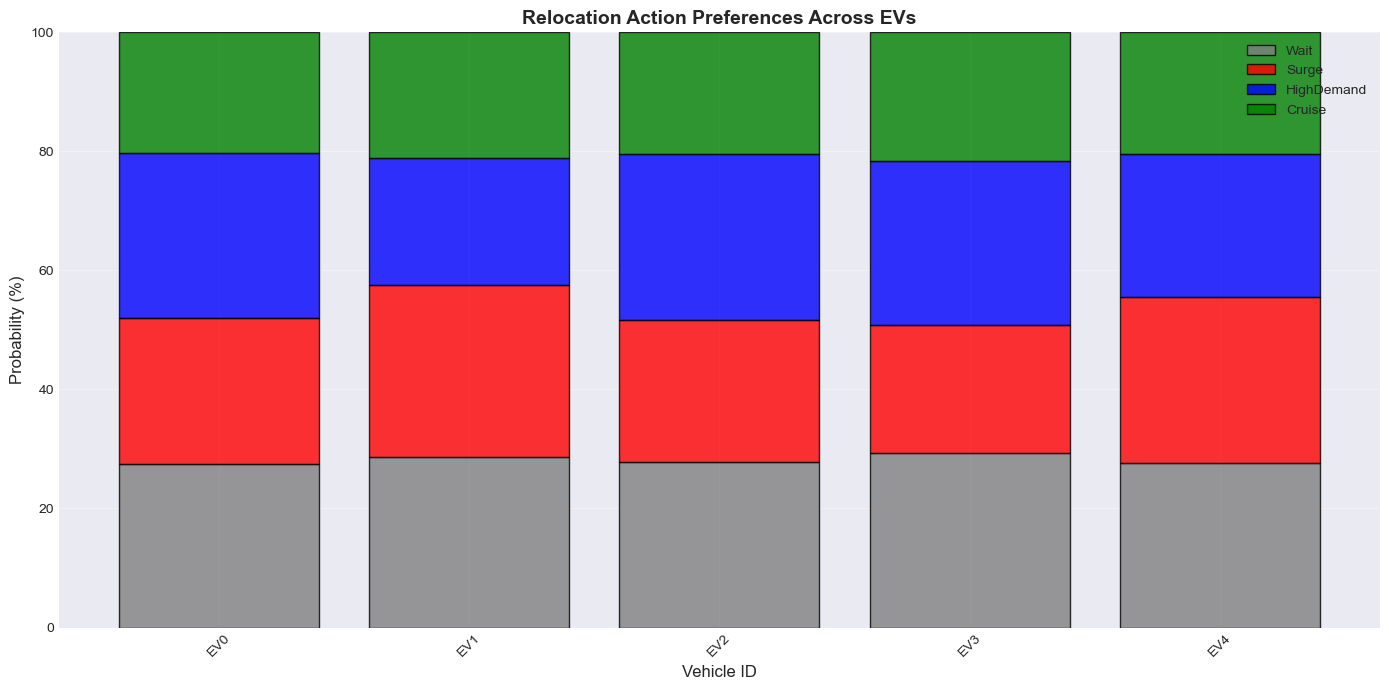

✓ Chart saved to results/multi_vehicle_relocation.png


In [7]:
# Collect all EV vehicles
ev_vehicles = [(vid, v) for vid, v in env.vehicles.items() if v['type'] == 1]

print(f"Found {len(ev_vehicles)} EV vehicles")

# Analyze relocation preferences for each EV
vehicle_reloc_data = []

for ev_id, vehicle in ev_vehicles:
    reloc_probs = env.compute_ev_relocation_probability(ev_id)
    vehicle_reloc_data.append({
        'Vehicle ID': ev_id,
        'Location': vehicle['location'],
        'Coordinates': vehicle['coordinates'],
        'Battery': vehicle['battery'],
        'Wait': reloc_probs.get('Wait', 0) * 100,
        'Surge': reloc_probs.get('Surge', 0) * 100,
        'HighDemand': reloc_probs.get('HighDemand', 0) * 100,
        'Cruise': reloc_probs.get('Cruise', 0) * 100
    })

vehicle_reloc_df = pd.DataFrame(vehicle_reloc_data)

print("\n=== EV Relocation Preferences ===")
print(vehicle_reloc_df.to_string(index=False))

# Visualize as stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

vehicle_ids = [f"EV{vid}" for vid in vehicle_reloc_df['Vehicle ID']]
actions = ['Wait', 'Surge', 'HighDemand', 'Cruise']
colors_list = ['gray', 'red', 'blue', 'green']

bottom = np.zeros(len(vehicle_ids))

for action, color in zip(actions, colors_list):
    values = vehicle_reloc_df[action].values
    ax.bar(vehicle_ids, values, bottom=bottom, label=action, color=color, alpha=0.8, edgecolor='black')
    bottom += values

ax.set_xlabel('Vehicle ID', fontsize=12)
ax.set_ylabel('Probability (%)', fontsize=12)
ax.set_title('Relocation Action Preferences Across EVs', fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('results/multi_vehicle_relocation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Chart saved to results/multi_vehicle_relocation.png")

## 5. Relocation Target Heatmap

Visualize preferred relocation zones across the grid

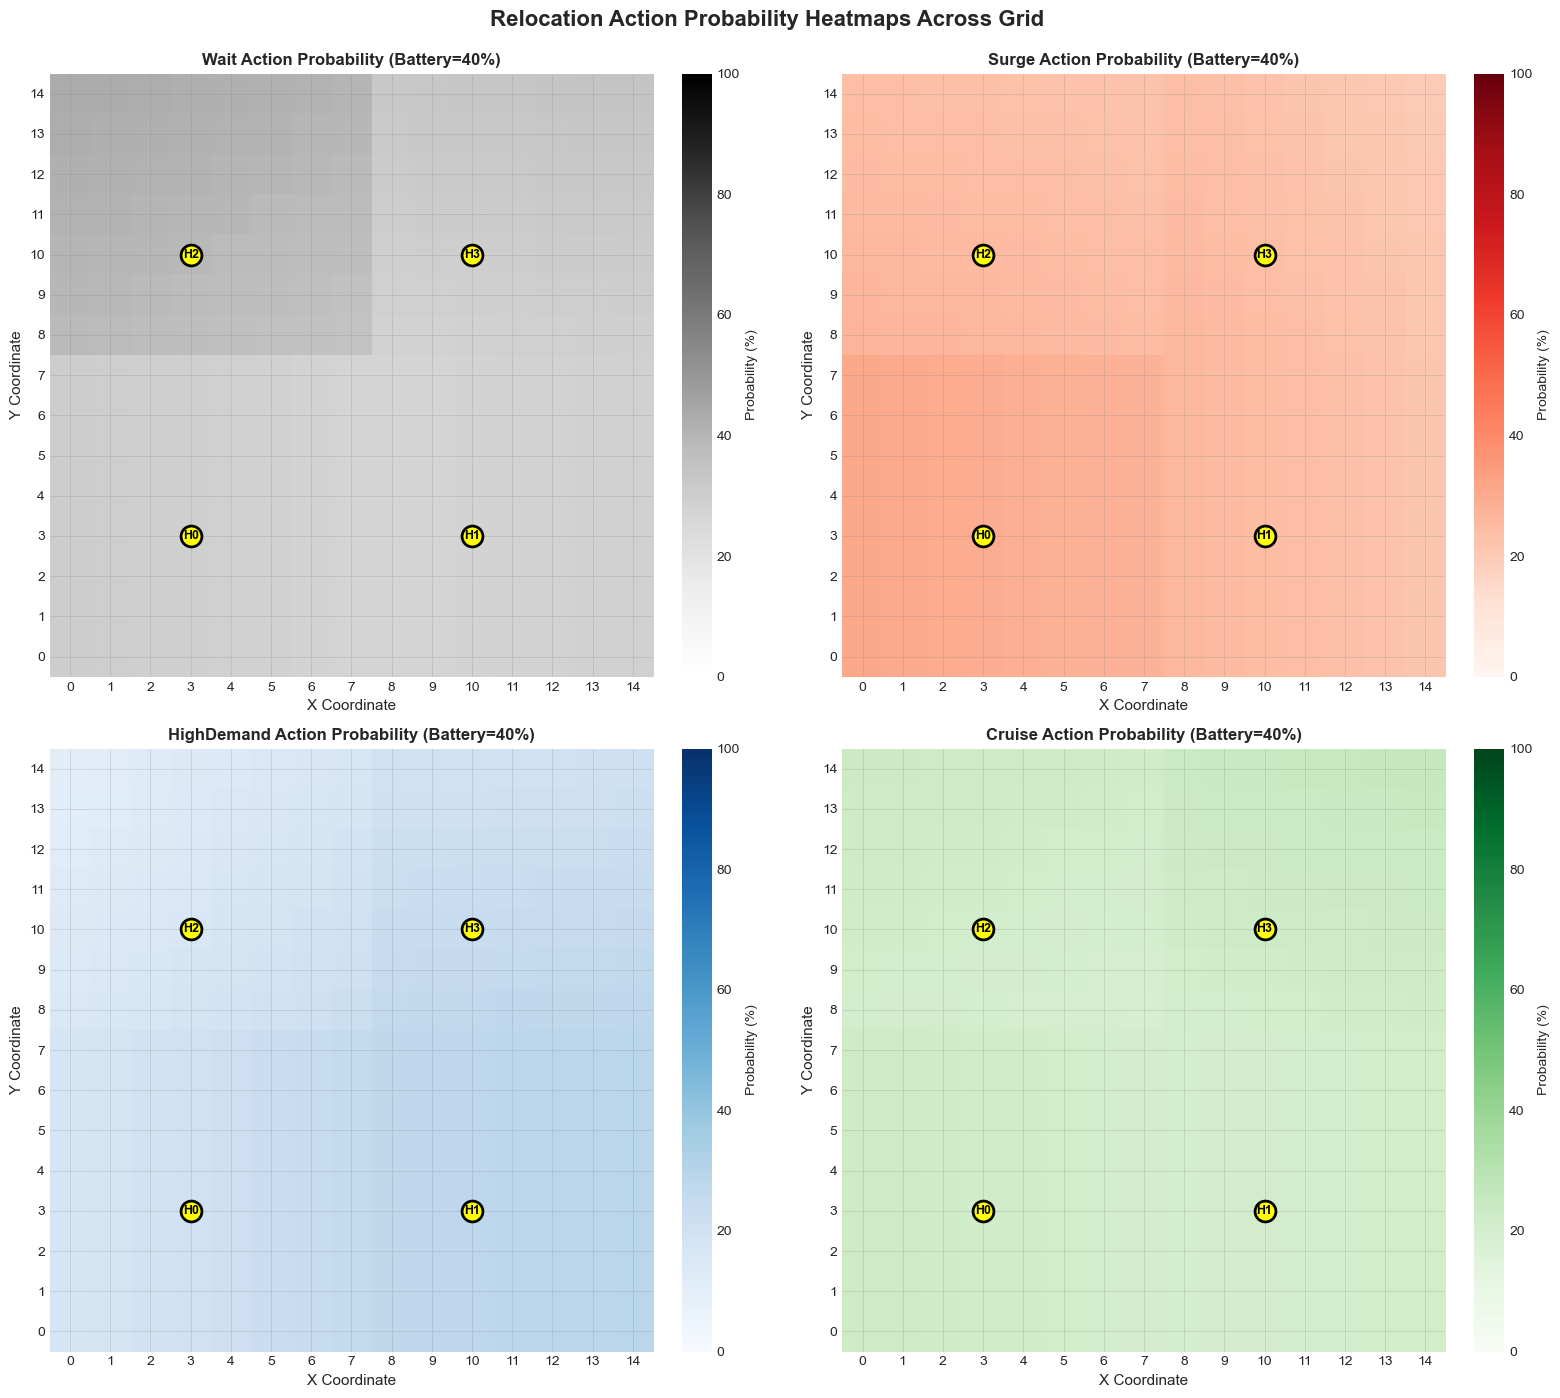

✓ Heatmaps saved to results/relocation_heatmaps.png

📊 Relocation Probability Statistics:

Wait:
  Average: 31.64%
  Maximum: 43.01%
  Minimum: 26.96%

Surge:
  Average: 25.19%
  Maximum: 30.50%
  Minimum: 19.75%

HighDemand:
  Average: 21.84%
  Maximum: 28.72%
  Minimum: 10.33%

Cruise:
  Average: 21.32%
  Maximum: 25.30%
  Minimum: 18.64%


In [8]:
# Create relocation preference heatmap for each action
grid_size = env.grid_size
test_battery = 0.4  # Test at 40% battery

# Create grids for each action
action_grids = {
    'Wait': np.zeros((grid_size, grid_size)),
    'Surge': np.zeros((grid_size, grid_size)),
    'HighDemand': np.zeros((grid_size, grid_size)),
    'Cruise': np.zeros((grid_size, grid_size))
}

if ev_id is not None:
    original_location = env.vehicles[ev_id]['location']
    original_battery = env.vehicles[ev_id]['battery']
    
    # Scan all grid positions
    for x in range(grid_size):
        for y in range(grid_size):
            location = y * grid_size + x
            env.vehicles[ev_id]['location'] = location
            env.vehicles[ev_id]['coordinates'] = (x, y)
            env.vehicles[ev_id]['battery'] = test_battery
            
            reloc_probs = env.compute_ev_relocation_probability(ev_id)
            
            for action in action_grids.keys():
                action_grids[action][y, x] = reloc_probs.get(action, 0)
    
    # Restore original state
    env.vehicles[ev_id]['location'] = original_location
    env.vehicles[ev_id]['coordinates'] = (original_location % grid_size, original_location // grid_size)
    env.vehicles[ev_id]['battery'] = original_battery
    
    # Plot heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    
    colors_map = {'Wait': 'Greys', 'Surge': 'Reds', 'HighDemand': 'Blues', 'Cruise': 'Greens'}
    
    for idx, (action, grid) in enumerate(action_grids.items()):
        ax = axes[idx]
        
        im = ax.imshow(grid * 100, cmap=colors_map[action], interpolation='nearest', 
                      vmin=0, vmax=100, origin='lower')
        
        # Mark hotspots
        for hidx, (hx, hy) in enumerate(env.hotspot_locations):
            ax.plot(hx, hy, 'o', color='yellow', markersize=15, 
                   markeredgecolor='black', markeredgewidth=2)
            ax.text(hx, hy, f'H{hidx}', ha='center', va='center', 
                   fontsize=9, fontweight='bold', color='black')
        
        ax.set_xticks(range(grid_size))
        ax.set_yticks(range(grid_size))
        ax.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.set_xlabel('X Coordinate', fontsize=11)
        ax.set_ylabel('Y Coordinate', fontsize=11)
        ax.set_title(f'{action} Action Probability (Battery={test_battery*100:.0f}%)', 
                    fontsize=12, fontweight='bold')
        
        plt.colorbar(im, ax=ax, label='Probability (%)', fraction=0.046, pad=0.04)
    
    plt.suptitle('Relocation Action Probability Heatmaps Across Grid', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('results/relocation_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Heatmaps saved to results/relocation_heatmaps.png")
    
    # Print statistics
    print("\n📊 Relocation Probability Statistics:")
    for action, grid in action_grids.items():
        print(f"\n{action}:")
        print(f"  Average: {np.mean(grid)*100:.2f}%")
        print(f"  Maximum: {np.max(grid)*100:.2f}%")
        print(f"  Minimum: {np.min(grid)*100:.2f}%")

## 6. Hotspot Distance Analysis

Analyze how distance to hotspots affects relocation decisions


=== Distance from EV 4 to Hotspots ===
Hotspot Coordinates  Distance
     H0      (3, 3)         6
     H1     (10, 3)         7
     H2     (3, 10)        13
     H3    (10, 10)        14


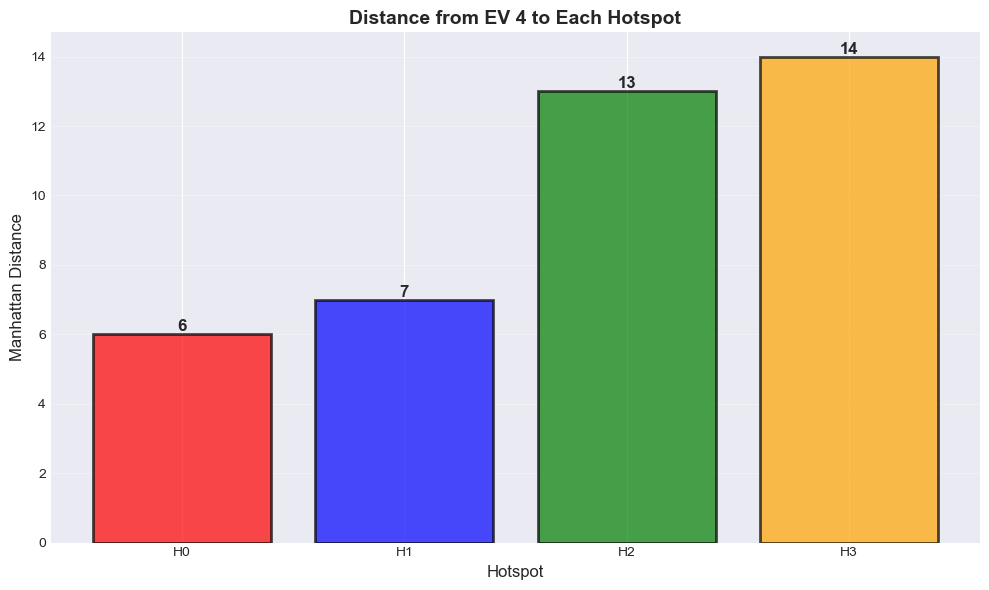

✓ Chart saved to results/hotspot_distances.png


In [9]:
# Calculate distance to each hotspot for the current EV
if ev_id is not None:
    ev_x, ev_y = env.vehicles[ev_id]['coordinates']
    
    hotspot_distances = []
    for idx, (hx, hy) in enumerate(env.hotspot_locations):
        distance = abs(ev_x - hx) + abs(ev_y - hy)
        hotspot_distances.append({
            'Hotspot': f'H{idx}',
            'Coordinates': f'({hx}, {hy})',
            'Distance': distance
        })
    
    distance_df = pd.DataFrame(hotspot_distances)
    print(f"\n=== Distance from EV {ev_id} to Hotspots ===")
    print(distance_df.to_string(index=False))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(distance_df['Hotspot'], distance_df['Distance'], 
                 color=['red', 'blue', 'green', 'orange'], alpha=0.7, edgecolor='black', linewidth=2)
    
    for bar, dist in zip(bars, distance_df['Distance']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(dist)}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_xlabel('Hotspot', fontsize=12)
    ax.set_ylabel('Manhattan Distance', fontsize=12)
    ax.set_title(f'Distance from EV {ev_id} to Each Hotspot', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('results/hotspot_distances.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✓ Chart saved to results/hotspot_distances.png")

## 7. Summary and Insights

Key findings about EV relocation behavior

In [ ]:
print("="*60)
print("🎯 EV Relocation Behavior Analysis Summary")
print("="*60)

print("\n📊 Key Findings:")
print("1. Four relocation actions available: Wait, Surge, HighDemand, Cruise")
print("2. Four strategic hotspot zones for vehicle positioning")
print("3. Relocation decisions influenced by battery level and location")
print("4. Spatial distribution shows clustering around hotspots")

print("\n🔍 Model Characteristics:")
print("- Uses nested logit model for relocation decisions")
print("- Considers distance to hotspots and demand patterns")
print("- Battery level affects willingness to relocate")
print("- Different actions correspond to different demand scenarios")

print("\n💡 Strategic Insights:")
print("- Surge: Quick response to sudden demand spikes")
print("- HighDemand: Position in consistently busy areas")
print("- Cruise: Proactive exploration for opportunities")
print("- Wait: Conservative strategy when battery is low")

print("\n🚗 Operational Recommendations:")
print("- Deploy EVs strategically near hotspots")
print("- Balance between proactive and reactive positioning")
print("- Consider battery constraints in relocation decisions")
print("- Monitor hotspot utilization for dynamic adjustments")

print("\n" + "="*60)